<a href="https://colab.research.google.com/github/ShubhsK04/IITB-Internship/blob/main/Movie_Recommendation(collaborative_filtering)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from inspect import ismethoddescriptor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras import optimizers
import seaborn as sns

movielens_data_file_url=(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

## New data

In [2]:
movielens_data_file_url=(
    "https://files.grouplens.org/datasets/movielens/ml-latest.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

350896731/350896731 [==============================] - 23s 0us/step
Extracting all the files now...
Done!


In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [4]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
user_ids= df["userId"].unique().tolist()
user2user_encoded = {x:i for i,x in enumerate(user_ids)}
userencoder2user = {i:x for i , x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 330975, Number of Movies: 83239, Min rating: 0.5, Max rating: 5.0


In [8]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_test, y_train, y_test = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [9]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)#change1
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)#change2


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    steps_per_epoch=1000,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_test, y_test),
)

Epoch 1/5
1000/1000 [==============================] - 220s 215ms/step - loss: 0.6826 - accuracy: 0.1239 - val_loss: 0.6721 - val_accuracy: 0.1417
Epoch 2/5
1000/1000 [==============================] - 214s 214ms/step - loss: 0.6608 - accuracy: 0.1431 - val_loss: 0.6466 - val_accuracy: 0.1472
Epoch 3/5
1000/1000 [==============================] - 173s 174ms/step - loss: 0.6322 - accuracy: 0.1472 - val_loss: 0.6244 - val_accuracy: 0.1469
Epoch 4/5
1000/1000 [==============================] - 173s 173ms/step - loss: 0.6229 - accuracy: 0.1483 - val_loss: 0.6233 - val_accuracy: 0.1469
Epoch 5/5
1000/1000 [==============================] - 213s 214ms/step - loss: 0.6241 - accuracy: 0.1445 - val_loss: 0.6230 - val_accuracy: 0.1471


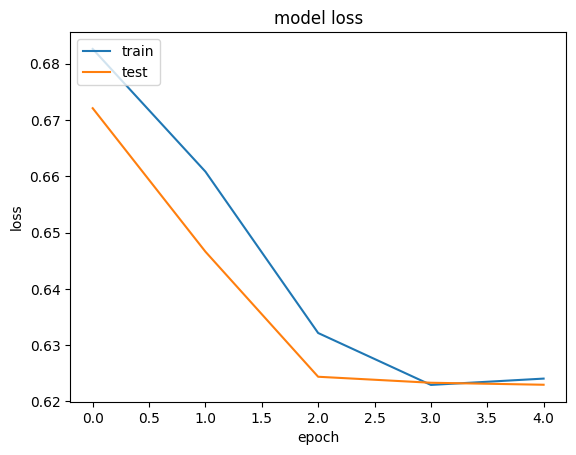

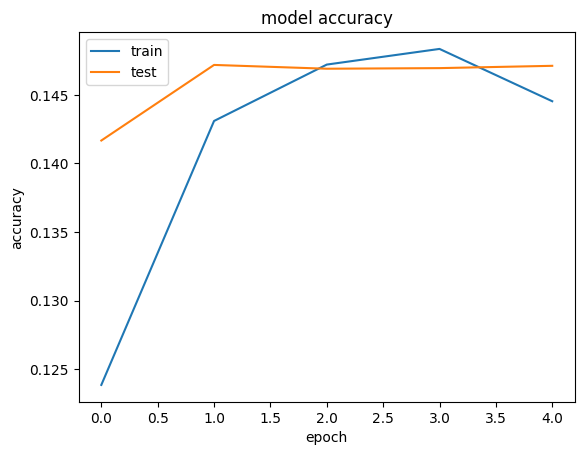

In [11]:

#plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [12]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

2582/2582 [==============================] - 6s 2ms/step
Showing recommendations for user: 309757
Movies with high ratings from user
--------------------------------
Contact (1997) : Drama|Sci-Fi
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
Spider-Man 3 (2007) : Action|Adventure|Sci-Fi|Thriller|IMAX
WALL·E (2008) : Adventure|Animation|Children|Romance|Sci-Fi
Scott Pilgrim vs. the World (2010) : Action|Comedy|Fantasy|Musical|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Léon: The Professional (a.k.a. The Professional) (Léon) (1994) : Action|Crime|Drama|Thriller
Schindler's List (1993) : Drama|War
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
Fargo (1996) : Comedy|Crime|Drama|Thriller
Casablanca (1942) : Drama|Romance
One Flew Over the Cuckoo's Nest (1975) : Drama
Goodfellas (1990) : Crime|Drama
Spirited Away (Sen to Chihiro no kamikakushi) (200